# Are the Doppler oscillations also explained by tracking signal lag?

Doppler residual oscillations of 50 mHz, or almost 1 mm/s given NEAR's X-band carrier, were obtained in the post-encounter Canberra track against the pre-encounter trajectory inferred from Goldstone data ([Refs](../README.md#references) [1, 3]).

The possibility that the same tracking signal lags caused these oscillations, as suggested in [Ref](../README.md#references) [8] is correspondingly explored below by constructing the orbital elements from the Goldstone LOS state from Horizons to compute the post-encounter trajectory lagging signal and a least square fit post-encounter trajectory, to mimic JPL's procedure. 

In [1]:
from astropy import units as u
from astropy import constants as const
from astropy.time import Time

from poliastro.util import norm
from poliastro.frames import Planes
from poliastro.ephem import Ephem
from poliastro.bodies import Earth

from poliastro.twobody.orbit import Orbit
from poliastro.twobody.sampling import EpochsArray

from astropy.coordinates import solar_system_ephemeris

import numpy as np
import sys
sys.path.append('../')

from sim.stations import dss25, dss34
from sim.tracking import Tracking
from sim.util import describe_orbit, describe_state, describe_trajectory, compare_orbits

solar_system_ephemeris.set("de440")
goldstone_end = Tracking.NEAR_GOLDSTONE_END.value
canberra_start = Tracking.NEAR_CANBERRA_START.value
canberra_end = canberra_start + 10*u.day

In [2]:
sampling_interval = 600
sample_offsets = np.arange(0, (canberra_end-canberra_start)/(1*u.s), sampling_interval)
flyby_epochs = canberra_start + (sample_offsets << u.s)
print("Start and end epochs:", flyby_epochs[0], flyby_epochs[-1], "[", flyby_epochs.size, "]")

Start and end epochs: 1998-01-23 09:53:55.600 1998-02-02 09:43:55.600 [ 1440 ]


In [3]:
near_goldstone_ephem = Ephem.from_horizons("NEAR", goldstone_end, attractor=Earth, plane=Planes.EARTH_EQUATOR)
near_goldstone_end_rv = near_goldstone_ephem.rv(goldstone_end)
describe_state(near_goldstone_end_rv, dss25, goldstone_end)

near_goldstone_orbit = Orbit.from_vectors(Earth, near_goldstone_end_rv[0], near_goldstone_end_rv[1], goldstone_end)
describe_orbit(near_goldstone_orbit)


:AT: 1998-01-23 06:14:55.600
Geocentric distance: 37471.700215992445 km speed: 8.258344936971223 km / s
From Goldstone-25 : range  31576.174442159892 km , range rate  -7.684513660227914 km / s

::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.97266698121356 deg
Eccentricity: 1.813357091534396
Semilatus rectum: 19437.250829758486 km
Semimajor axix: -8494.322039490264 km
Periapse radius: 6908.917068596319 km , altitude: 530.7804685963192 km


In [4]:
near_extended_ephem = near_goldstone_orbit.to_ephem(EpochsArray(flyby_epochs))
describe_trajectory(near_extended_ephem, dss34)


::TRAJECTORY::
Start and end ranges: 77530.78379128852 km 6021453.339081134 km
Start and end radial speeds: 7.3216176182785535 km / s 6.754134503862803 km / s
Closest: 73145.82143191747 km speed 7.5891622264313146 km / s  at  1998-01-23 09:53:55.600
Deflection: 0.4578515127375158 deg


In [5]:
sim_meas = []

for e in flyby_epochs:
    rv = near_extended_ephem.rv(e)
    ref_r, ref_rr, ref_ra = dss34.range_rate_accel(rv, e)
    sim_meas.append([ref_rr - ref_ra*ref_r/const.c])

#print(sim_meas)

In [6]:
from sim.fitorbit import OrbitFitter
fitter = OrbitFitter(near_goldstone_orbit, [dss34], var=0.001, debug=True)

Range constraints:
a: -8485827.717450773 -8502816.361529753
ecc: 1.8115437344428615 1.8151704486259301
inc: 1.8825940624405615 1.8863630195225243


In [7]:
from datetime import datetime 
start_time = datetime.now()
#print(start_time)

fitter.fit_doppler_data(flyby_epochs, sim_meas)
time_elapsed = datetime.now() - start_time
print(fitter.report())
print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

describe_orbit(fitter.orbit)
describe_trajectory(fitter.ephem, dss34)

{'a': -8494322.039490264, 'ecc': 1.813357091534396, 'inc': 1.884478540981543, 'nu': -1.8394247601999354, 'raan': 1.540059254992049, 'argp': 2.533258385194789}
{'a': -8494322.039490264, 'ecc': 1.813357091534396, 'inc': 1.884478540981543, 'nu': -1.8394247601999354, 'raan': 1.540059254992049, 'argp': 2.533258385194789}
{'a': -8494322.039490264, 'ecc': 1.813357091534396, 'inc': 1.884478540981543, 'nu': -1.8394247601999354, 'raan': 1.540059254992049, 'argp': 2.533258385194789}
{'a': -8494322.039490264, 'ecc': 1.813357091534396, 'inc': 1.884478540981543, 'nu': -1.8394247601999354, 'raan': 1.540059254992049, 'argp': 2.533258385194789}
{'a': -8494322.039490264, 'ecc': 1.813357091534396, 'inc': 1.884478540981543, 'nu': -1.8394247601999354, 'raan': 1.540059254992049, 'argp': 2.533258385194789}
{'a': -8494322.039490264, 'ecc': 1.813357091534396, 'inc': 1.884478540981543, 'nu': -1.8394247601999354, 'raan': 1.540059254992049, 'argp': 2.533258385194789}
{'a': -8494322.039490264, 'ecc': 1.81335709153

In [8]:
print(fitter.result.residual)

[ 0.00391632  0.00371267  0.00339844 ... -0.00045914 -0.00046148
 -0.00046336]


In [9]:
fitted_ephem = fitter.ephem
describe_trajectory(fitted_ephem, dss34)


::TRAJECTORY::
Start and end ranges: 77525.281540802 km 6021448.205722353 km
Start and end radial speeds: 7.321639711817377 km / s 6.754134261314694 km / s
Closest: 73140.30629359183 km speed 7.589215028967128 km / s  at  1998-01-23 09:53:55.600
Deflection: 0.4579141563326192 deg


The result indeed presents oscillations of similar magnitude, validating the signal lags hypothesis. The 3d visualization shows that the oscillations are entirely due to the lags and Earth rotation, as the trajectory itself is essentially linear and unchanged..

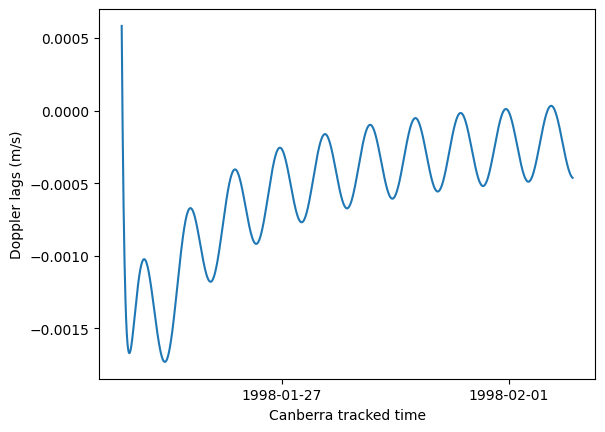

In [10]:
import matplotlib.pyplot as plt
from astropy import visualization
with visualization.time_support():
    plt.xlabel('Canberra tracked time')
    plt.ylabel('Doppler residuals (m/s)')
    plt.plot(flyby_epochs[10:], fitter.result.residual[10:])

In [11]:
from czml3.widget import CZMLWidget
from poliastro.czml.extract_czml import CZMLExtractor

czml = CZMLExtractor(flyby_epochs[0], flyby_epochs[-1], flyby_epochs.size)
dss34.add_to_czml(czml, "#333")
czml.add_orbit(near_goldstone_orbit)
czml.add_orbit(fitter.orbit)

CZMLWidget(czml.get_document())

CZMLWidget(document=Document(_values=[Preamble(id='document', version='1.0', name='document_packet', description=None, clock=IntervalValue(_start=<Time object: scale='tdb' format='isot' value=1998-01-23T09:53:55.600>, _end=<Time object: scale='tdb' format='isot' value=1998-02-02T09:43:55.600>, _value=Clock(currentTime=datetime.datetime(1998, 1, 23, 9, 53, 55, 600000, tzinfo=datetime.timezone.utc), multiplier=60, range=<ClockRanges.LOOP_STOP: 3>, step=<ClockSteps.SYSTEM_CLOCK_MULTIPLIER: 2>))), Packet(id='custom_properties', delete=None, name=None, parent=None, description=None, availability=None, properties={'custom_attractor': True, 'ellipsoid': [{'array': (6378136.6, 6378136.6, 6356751.9)}], 'map_url': ('https://upload.wikimedia.org/wikipedia/commons/c/c4/Earthmap1000x500compac.jpg',), 'scene3D': True}, position=None, orientation=None, viewFrom=None, billboard=None, box=None, corridor=None, cylinder=None, ellipse=None, ellipsoid=None, label=None, model=None, path=None, point=None, polygon=None, polyline=None, rectangle=None, tileset=None, wall=None), Packet(id='GS0', delete=None, name=None, parent=None, description='Canberra-34', availability=TimeInterval(_start=<Time object: scale='tdb' format='isot' value=1998-01-23T09:53:55.600>, _end=<Time object: scale='tdb' format='isot' value=1998-02-02T09:43:55.600>), properties=None, position=Position(epoch=None, interpolationAlgorithm=None, interpolationDegree=None, delete=None, referenceFrame=None, cartesian=[-4460663.355092975, 2682148.4171565603, -3673992.042646422], cartographicRadians=None, cartographicDegrees=None, cartesianVelocity=None, reference=None), orientation=None, viewFrom=None, billboard=Billboard(horizontalOrigin=None, verticalOrigin=None, image='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAABAAAAAQCAYAAAAf8/9hAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAADsMAAA7DAcdvqGQAAACvSURBVDhPrZDRDcMgDAU9GqN0lIzijw6SUbJJygUeNQgSqepJTyHG91LVVpwDdfxM3T9TSl1EXZvDwii471fivK73cBFFQNTT/d2KoGpfGOpSIkhUpgUMxq9DFEsWv4IXhlyCnhBFnZcFEEuYqbiUlNwWgMTdrZ3JbQFoEVG53rd8ztG9aPJMnBUQf/VFraBJeWnLS0RfjbKyLJA8FkT5seDYS1Qwyv8t0B/5C2ZmH2/eTGNNBgMmAAAAAElFTkSuQmCC', show=True, scale=None, eyeOffset=None), box=None, corridor=None, cylinder=None, ellipse=None, ellipsoid=None, label=Label(horizontalOrigin=None, verticalOrigin=None, show=True, text=None, font='11pt Lucida Console', style=<LabelStyles.FILL: 1>, scale=None, showBackground=None, backgroundColor=None, fillColor=Color(epoch=None, interpolationAlgorithm=None, interpolationDegree=None, delete=None, rgba='#333', rgbaf=None), outlineColor=None, outlineWidth=1.0, pixelOffset=None), model=None, path=None, point=None, polygon=None, polyline=None, rectangle=None, tileset=None, wall=None), Packet(id=0, delete=None, name=None, parent=None, description=None, availability=TimeInterval(_start=<Time object: scale='tdb' format='isot' value=1998-01-23T09:53:55.600>, _end=<Time object: scale='tdb' format='isot' value=1998-02-02T09:43:55.600>), properties=None, position=Position(epoch=datetime.datetime(1998, 1, 23, 9, 53, 55, 600000, tzinfo=datetime.timezone.utc), interpolationAlgorithm=<InterpolationAlgorithms.LAGRANGE: 2>, interpolationDegree=5, delete=None, referenceFrame=<ReferenceFrames.INERTIAL: 2>, cartesian=[0.0, -23066429.325660363, -13266561.435151586, -69816140.89872718, 599.5833333333, -24469796.413572066, -13367747.372881254, -74130652.27938978, 1199.1666666667, -25866094.262115207, -13465065.965275666, -78423748.08782431, 1798.75, -27256055.11095239, -13559081.595375434, -82697631.0548046, 2398.3333333333, -28640301.270264868, -13650251.169520313, -86954175.37514089, 2997.9166666667, -30019366.265460607, -13738948.88210281, -91194989.5132406, 3597.5, -31393711.10570568, -13825484.376867257, -95421464.60964164, 4197.0833333333, -32763736.970211003, -13910116.283323573, -99634812.28797582, 4796.6666666667, -34129795.22188965, -13993062.454378283, -103836094.53946441, 5396.25, -35492195.39895478, -14074507.812017698, -108026247.60359065, 59

See [screenshot](near_sim_postencounter_doppler.png)